# Notebook for reproducing SI figure of simulation performance

3 methods: `fftconvolve`, `raytracing`, `direct` are compared. Performance only made for 1 core

In [10]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps
from tqdm.auto import tqdm

from mbhl import *

In [2]:
# Setting the number of threads for NumPy operations
%env OMP_NUM_THREADS=1
%env MKL_NUM_THREADS=1
%env OPENBLAS_NUM_THREADS=1
%env VECLIB_MAXIMUM_THREADS=1

env: OMP_NUM_THREADS=1
env: MKL_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=1
env: VECLIB_MAXIMUM_THREADS=1


In [3]:
%mkdir -p subfigs-SI-performance

In [4]:
def calculate_timing(
    delta=0 * nm,
    phi=5,
    theta=30,
    gap=2.5 * um,
    n_pts=1,
    resolution=128,
    r=50 * nm,
    Lr_ratio=4,
    method="fft",
):
    phi = np.deg2rad(phi)
    theta = np.deg2rad(theta)
    L = r * Lr_ratio
    h = L / resolution
    R = np.tan(phi) * gap
    geom = square_hole_lattice(r, L)
    stencil = Stencil(geom, thickness=delta, gap=gap, h=h)
    phys = Physics(n_beam_trajectory(phi, theta_0=theta, n_pts=n_pts))
    system = System(stencil, phys)
    t_ = time.perf_counter()
    system.simulate(method=method, fold_to_bz=True)
    t_el = time.perf_counter() - t_
    return t_el, h

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Text(0.5, 0, 'Mesh spacing h (nm)')

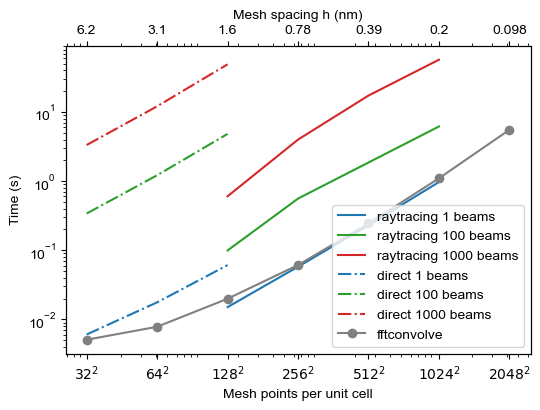

In [18]:
color_map = colormaps["tab10"]
n_pts_values = [1, 10, 100, 1000]
n_pts_colors = {n_pts: color_map(i) for i, n_pts in enumerate(n_pts_values)}

fig, ax = plt.subplots(figsize=(6, 4))
ax2 = plt.twiny(ax)
res_list = np.logspace(start=5, stop=11, num=7, base=2)
n_mesh = res_list**2
t_fft = []
h_list = []
for res in tqdm(res_list):
    t, h = calculate_timing(n_pts=360, method="fft", resolution=res)
    t_fft.append(t)
    h_list.append(h)
h_list = np.array(h_list)


res_list_raytracing = np.logspace(start=7, stop=10, num=4, base=2)
t_rt = {}
for n_pts in (1, 100, 1000):
    local_t = []
    for res in tqdm(res_list_raytracing):
        t, h = calculate_timing(
            n_pts=n_pts, method="raytracing", resolution=res
        )
        local_t.append(t)
    local_t = np.array(local_t)
    ax.plot(
        res_list_raytracing**2,
        local_t,
        "-",
        color=n_pts_colors[n_pts],
        label=f"raytracing {n_pts} beams",
    )

res_list_raytracing = np.logspace(start=5, stop=7, num=3, base=2)
t_dir = {}
for n_pts in (1, 100, 1000):
    local_t = []
    for res in tqdm(res_list_raytracing):
        t, h = calculate_timing(n_pts=n_pts, method="direct", resolution=res)
        local_t.append(t)
    local_t = np.array(local_t)
    ax.plot(
        res_list_raytracing**2,
        local_t,
        "-.",
        color=n_pts_colors[n_pts],
        label=f"direct {n_pts} beams",
    )

ax.plot(n_mesh, t_fft, "-o", color="gray", label="fftconvolve")

n_ticks = [32, 64, 128, 256, 512, 1024, 2048]
n_tick_labels = [f"${n}^2$" for n in n_ticks]
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks([n**2 for n in n_ticks])
ax.set_xticklabels(n_tick_labels)
ax.set_ylabel("Time (s)")
ax.set_xlabel("Mesh points per unit cell")
ax.legend()

# # Top x-axis
ax2.set_xscale("log")
ax2.set_xticks([n**2 for n in n_ticks])
ax2.set_xlim(ax.get_xlim())  # Match limits with the bottom x-axis
ax2.set_xticklabels([f"{h:.2}" for h in h_list / nm])
ax2.set_xlabel("Mesh spacing h (nm)")

In [19]:
fig.savefig(Path("subfigs-SI-performance") / "timing.svg")